# Imaging Performance Comparison (Quiet Sun)
This notebook loops over different noise levels and calibration errors to generate, corrupt, image, and compare solar flare datasets.

In [2]:
import fasr_solar_simul as fss
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1
from scipy.constants import c
import os
from casatasks import tclean, applycal, clearcal
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
from astropy.time import Time
from sunpy import coordinates

# Speed of light in m/s
C_LIGHT = c
import matplotlib
%matplotlib inline

In [3]:
from importlib import reload

reload(fss)
target = 'Quiet_Sun'
figsubfolder = 'figs/'
model_dir = '../fasr_sim/skymodels/quiet_sun/'

# Imaging Performance Comparison
looping over different noise levels and calibration errors to generate, corrupt, image, and compare

## Set up the simulation

In [62]:
# List of all available frequencies in GHz
freq_list = ['1GHz', '2GHz', '5GHz', '10GHz', '20GHz']
imsizes = [512, 512, 1024, 2048, 4096]
cells = ['4.8arcsec', '4.8arcsec', '2.4arcsec', '1.2arcsec', '0.6arcsec']
scales = [[0, 5, 10, 50], [0, 4, 10, 40], [0, 6, 20, 80], [0, 5, 10, 40, 160], [0, 10, 40, 80, 320]]

selection = [0, 1]
# Revise freq_list, imsizes, cells, and scales using the selection
freq_list = [freq_list[i] for i in selection]
imsizes = [imsizes[i] for i in selection]
cells = [cells[i] for i in selection]
scales = [scales[i] for i in selection]


# List of configurations
project = 'FASR-A'
#config_files = ['fasr_Log_Spiral-168.cfg', 'fasr-a_random_spiral_hybrid_120.cfg']
config_files = ['fasr-a_random_spiral_hybrid_120.cfg']

## Antenna temperature noise levels
tsys_all = [300.]

## Define the fractional gain errors tuples: (phase and amplitude)
# 6 degrees (or 1.7% of phase error is equivalent to 10% of amplitude error )
#cal_errors = [(0., 0.), (0.017, 0.1)]
cal_errors = [(0., 0.)]

# Define channel width and integration time
channel_width_mhz = 24. # channel width in MHz
integration_time = 1. # Time per integration in seconds
duration = 1. # Total imaging duration in seconds

# Reference timestamp for the observation series
reftime='2020-11-26T20:45:47'
solar_radius_asec = coordinates.sun.angular_radius(reftime).value

# Flags to control overwriting existing data products
overwrite_ms   = False  # Overwrite measurement set?
overwrite_im   = False  # Overwrite image products?
overwrite_plot = True  # Overwrite existing plots?

weighting = 'uniform'
# Deconvolution algorithm choice
#deconvolver = 'hogbom'
#niter = 0

deconvolver = 'multiscale'
niter = 10000
 

## Mask Models based on background levels

Pixel scale: 1.20 x 1.20 arcsec
Minimum flux threshold: 0.0001 Jy/pixel at 1.00 GHz
Background level at 1.00 GHz: 0.0004 Jy/pixel


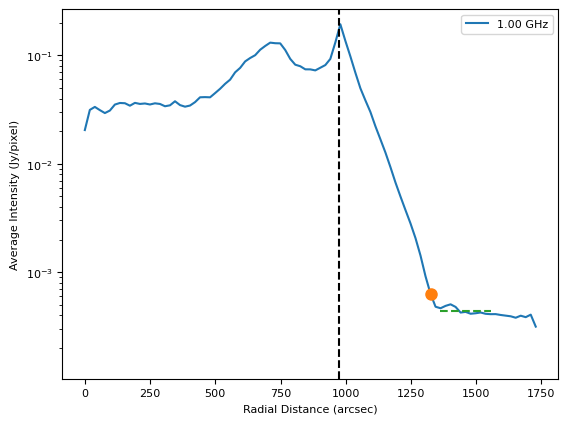

Masked solar model written to ../fasr_sim/skymodels/quiet_sun//solar_disk_model_20201126.1GHz.masked.fits (RADCUT=1324.80 arcsec)


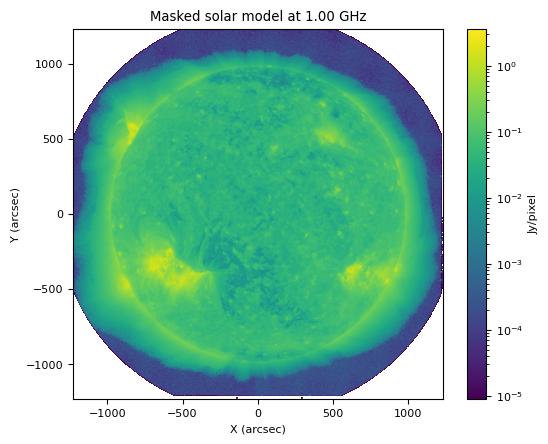

Pixel scale: 1.20 x 1.20 arcsec
Minimum flux threshold: 0.0004 Jy/pixel at 2.00 GHz
Background level at 2.00 GHz: 0.0018 Jy/pixel


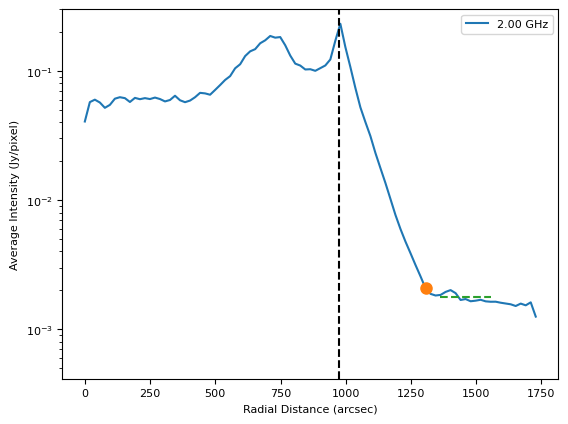

Masked solar model written to ../fasr_sim/skymodels/quiet_sun//solar_disk_model_20201126.2GHz.masked.fits (RADCUT=1305.60 arcsec)


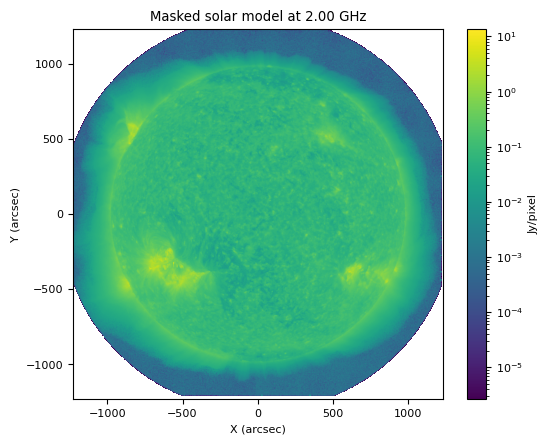

Pixel scale: 1.20 x 1.20 arcsec
Minimum flux threshold: 0.0017 Jy/pixel at 3.99 GHz
Background level at 3.99 GHz: 0.0070 Jy/pixel


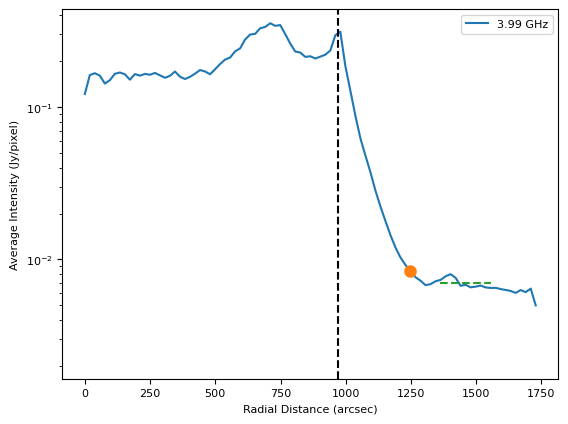

Masked solar model written to ../fasr_sim/skymodels/quiet_sun//solar_disk_model_20201126.4GHz.masked.fits (RADCUT=1248.00 arcsec)


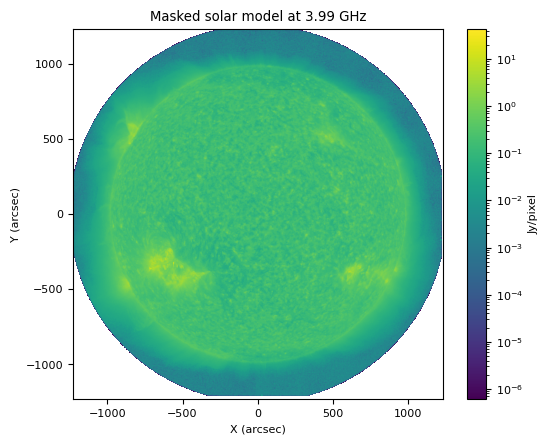

Pixel scale: 1.20 x 1.20 arcsec
Minimum flux threshold: 0.0026 Jy/pixel at 5.02 GHz
Background level at 5.02 GHz: 0.0111 Jy/pixel


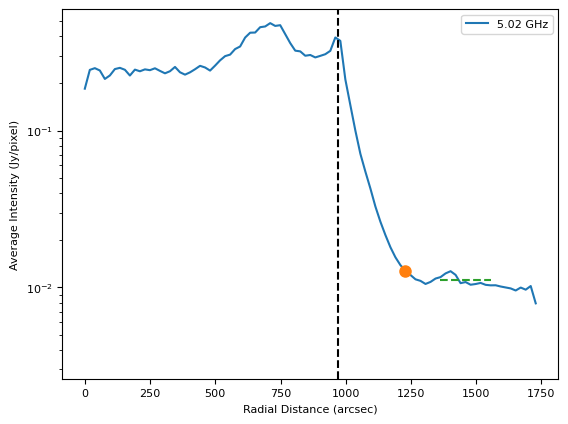

Masked solar model written to ../fasr_sim/skymodels/quiet_sun//solar_disk_model_20201126.5GHz.masked.fits (RADCUT=1228.80 arcsec)


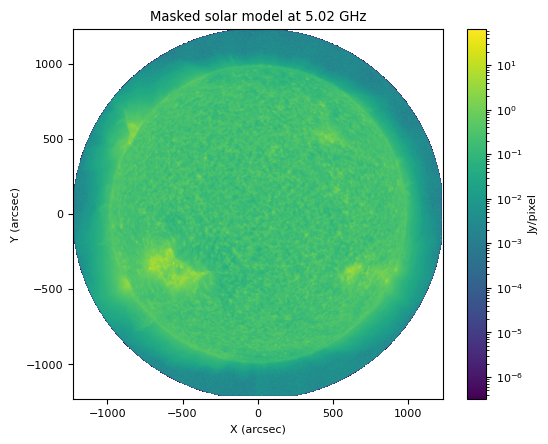

Pixel scale: 1.20 x 1.20 arcsec
Minimum flux threshold: 0.0066 Jy/pixel at 7.96 GHz
Background level at 7.96 GHz: 0.0280 Jy/pixel


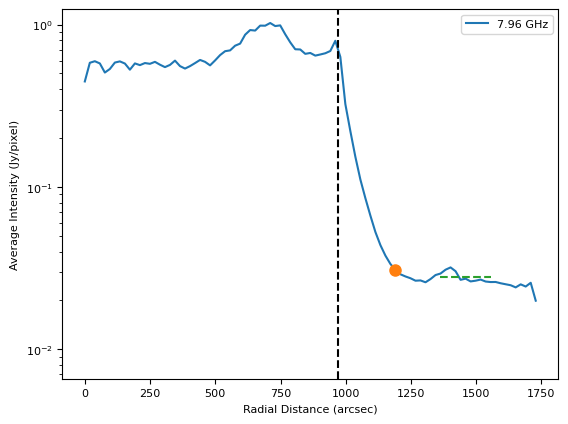

Masked solar model written to ../fasr_sim/skymodels/quiet_sun//solar_disk_model_20201126.8GHz.masked.fits (RADCUT=1190.40 arcsec)


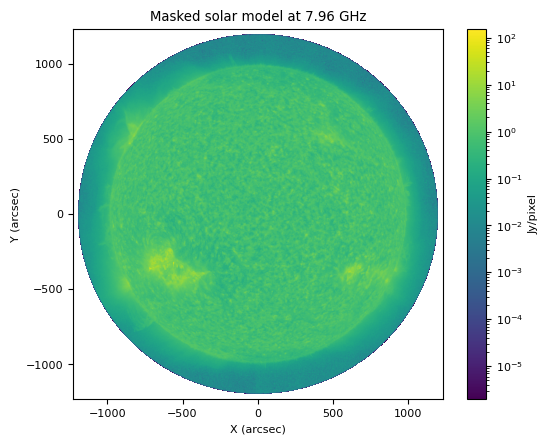

Pixel scale: 1.20 x 1.20 arcsec
Minimum flux threshold: 0.0104 Jy/pixel at 10.02 GHz
Background level at 10.02 GHz: 0.0444 Jy/pixel


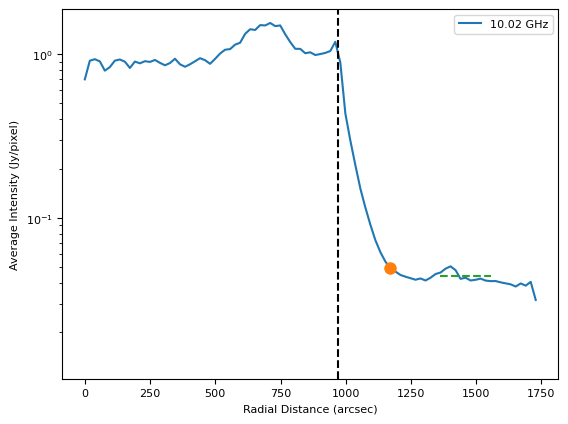

Masked solar model written to ../fasr_sim/skymodels/quiet_sun//solar_disk_model_20201126.10GHz.masked.fits (RADCUT=1171.20 arcsec)


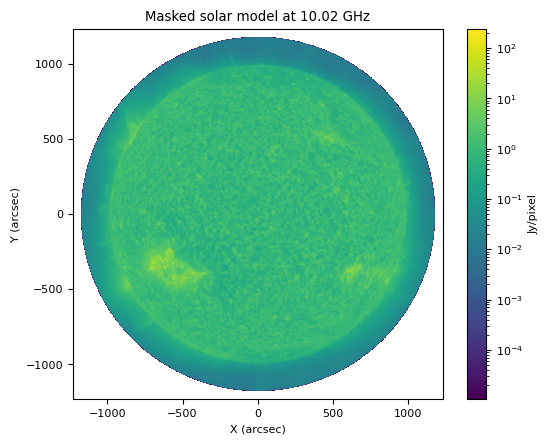

Pixel scale: 1.20 x 1.20 arcsec
Minimum flux threshold: 0.0225 Jy/pixel at 14.71 GHz
Background level at 14.71 GHz: 0.0957 Jy/pixel


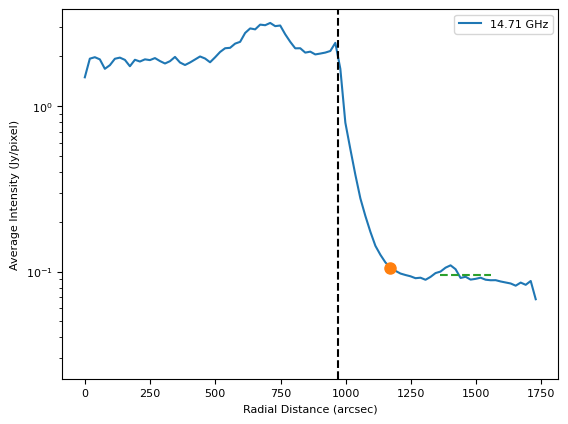

Masked solar model written to ../fasr_sim/skymodels/quiet_sun//solar_disk_model_20201126.15GHz.masked.fits (RADCUT=1171.20 arcsec)


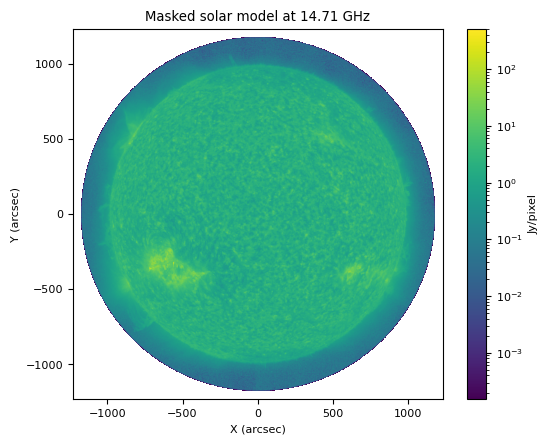

Pixel scale: 1.20 x 1.20 arcsec
Minimum flux threshold: 0.0416 Jy/pixel at 20.00 GHz
Background level at 20.00 GHz: 0.1769 Jy/pixel


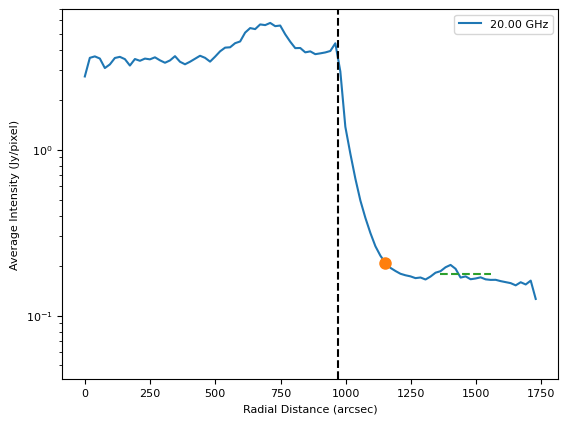

Masked solar model written to ../fasr_sim/skymodels/quiet_sun//solar_disk_model_20201126.20GHz.masked.fits (RADCUT=1152.00 arcsec)


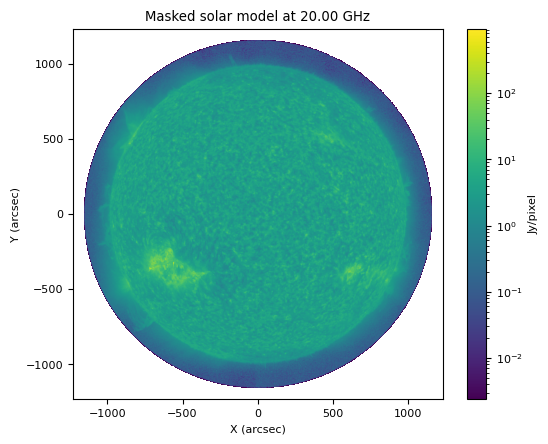

In [56]:
reload(fss)
freq_list=['1GHz', '2GHz', '4GHz', '5GHz', '8GHz','10GHz', '15GHz','20GHz']
radius_cutoffs = []
for freqstr in freq_list:
    solar_model = f'{model_dir}/solar_disk_model_20201126.{freqstr}.fits'
    radius_list, mean_intensity_profile, background_level, radius_cutoff = fss.calc_model_radial_profile(solar_model, dr=20, tb_min=100., bkg_radius_range=[1.4, 1.6], snr_min=1.1, apply_mask=True)
    radius_cutoffs.append(radius_cutoff)

In [30]:
from astropy.io import fits
solar_model_5ghz = f'{model_dir}/solar_disk_model_20201126.5GHz.fits'
hdul = fits.open(solar_model)
header = hdul[0].header
header['CRVAL3'] = 5.01827669e9
hdul.writeto(solar_model_5ghz, overwrite=True)
hdul.close()

## Simulate visibility and do imaging

Total flux within primary beam used to calcuate the antenna temperature: 21.6 sfu
Tant: 83K
UV Grid: 267 x 267 cells covering +/- 11242.7 wavelengths
21.648125
Calculate antenna temperature from total flux 21.648125 sfu incident on the dish
Total noise temperature (K): 3.831e+02 K
Estimated SEFD: 1072365.1465621886 Jy
Estimated natural weighting point source sensitivity per integration per channel sigma_na: 1.295e+00 Jy/beam
Estimated uniform weighting point source sensitivity per integration per channel sigma_un: 2.077e+00 Jy/beam
Estimated noise per baseline per channel per polarization per integration: 1.548e+02 Jy for 7140 baselines
Start plotting
Applying a mask of 1.4 solar radii to calcuate rms outside of it.
Peak of fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_1GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr0deg_amperr0pct_multiscale.image: 1.336e+06 K
rms of fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_1GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr0deg_amperr0pct_multiscal

/Users/binchen/Dropbox/Projects/FASR/fasr-array-config-simul/fasr_solar_simul.py:2708: UserWarning: FixedFormatter should only be used together with FixedLocator
  transform=ax1.transAxes, ha='left', va='top', color='white', fontsize=legend_size)
/Users/binchen/Dropbox/Projects/FASR/fasr-array-config-simul/fasr_solar_simul.py:2750: UserWarning: FixedFormatter should only be used together with FixedLocator
  


'plot_two_casa_images_with_convolution' completed at 2026-02-03 19:51:31; runtime: 0.31 seconds
Total flux within primary beam used to calcuate the antenna temperature: 29.4 sfu
Tant: 113K
UV Grid: 535 x 535 cells covering +/- 22485.4 wavelengths
29.432328125
Calculate antenna temperature from total flux 29.432328125 sfu incident on the dish
Total noise temperature (K): 4.130e+02 K
Estimated SEFD: 1156026.8495585562 Jy
Estimated natural weighting point source sensitivity per integration per channel sigma_na: 1.396e+00 Jy/beam
Estimated uniform weighting point source sensitivity per integration per channel sigma_un: 1.847e+00 Jy/beam
Estimated noise per baseline per channel per polarization per integration: 1.669e+02 Jy for 7140 baselines
Start plotting
Applying a mask of 1.3 solar radii to calcuate rms outside of it.
Peak of fasr_fasr-a_random_spiral_hybrid_120_Quiet_Sun_2GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr0deg_amperr0pct_multiscale.image: 5.578e+05 K
rms of fasr_fasr-a_rand

/Users/binchen/Dropbox/Projects/FASR/fasr-array-config-simul/fasr_solar_simul.py:2708: UserWarning: FixedFormatter should only be used together with FixedLocator
  transform=ax1.transAxes, ha='left', va='top', color='white', fontsize=legend_size)
/Users/binchen/Dropbox/Projects/FASR/fasr-array-config-simul/fasr_solar_simul.py:2750: UserWarning: FixedFormatter should only be used together with FixedLocator
  


'plot_two_casa_images_with_convolution' completed at 2026-02-03 19:51:31; runtime: 0.26 seconds


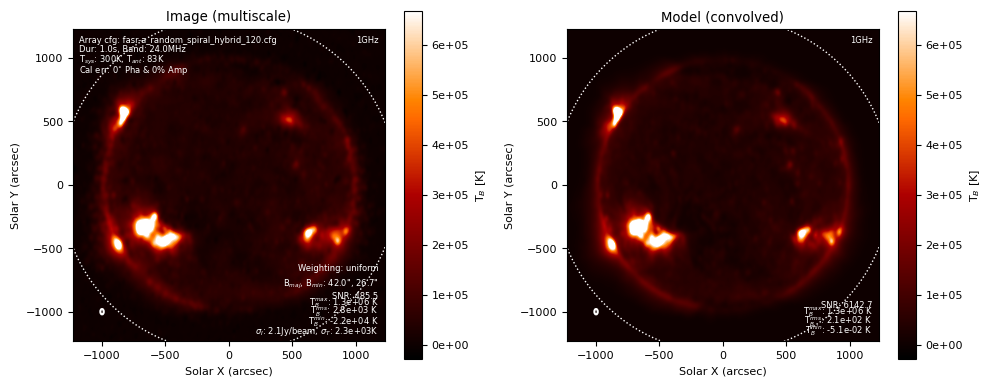

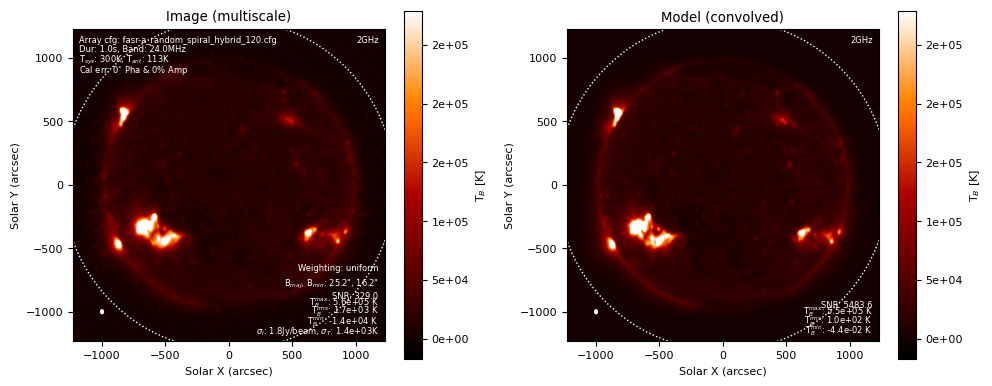

In [ ]:
%matplotlib inline
reload(fss)

import time

reftime_casa = Time(reftime).strftime('%Y/%m/%d/%H:%M:%S')

figdir = os.path.join(project, figsubfolder)
if not os.path.exists(figdir):
    os.makedirs(figdir)
    
caltbdir = os.path.join(project, 'caltbs')
if not os.path.exists(caltbdir):
    os.makedirs(caltbdir)

for config_file in config_files:
    cfg_suffix = os.path.basename(config_file.rstrip(".cfg"))
    for freqstr, imsize, cell, scale in zip(freq_list, imsizes, cells, scales):
        solar_model = f'{model_dir}/solar_disk_model_20201126.{freqstr}.masked.fits'
        for tsys in tsys_all:
            # Calculate theoretical sensitivity with natural weighting
            antenna_params = np.genfromtxt(config_file, comments='#')
            dish_diameter = antenna_params[0, 3]
            uv_cell = 1. / (imsize * float(cell.rstrip('arcsec')) / 206265.)
            total_flux = fss.calc_total_flux_on_dish(solar_model, dish_diameter=dish_diameter, freqghz=freqstr)
            tant = fss.total_flux_to_tant(total_flux, eta_a=0.6, dish_diameter=dish_diameter)
            print(f'Tant: {tant:.0f}K')
            noisejy, sigma_na, sigma_un = fss.calc_noise(tsys, config_file, dish_diameter=dish_diameter, 
                                                         total_flux=total_flux, duration=duration,
                                                         integration_time=integration_time, 
                                                         channel_width_mhz=channel_width_mhz, 
                                                         freqghz=freqstr, uv_cell=uv_cell)
            sigma_jy = sigma_un / np.sqrt((duration / integration_time))
                
            for phaerr, amperr in cal_errors:
                phaerr_deg = np.rad2deg(phaerr * 2 * np.pi)
                gaintable = [f'caltb_FASR_corrupt_{phaerr_deg:.0f}deg.ph',
                             f'caltb_FASR_corrupt_{np.int_(amperr * 100)}pct.amp']
                msname = fss.make_msname(project, target, freqstr, Time(reftime).datetime, duration, integration_time, config_file, tsys)
                imname = fss.make_imname(msname, deconvolver, phaerr, amperr)
                if niter == 0:
                    imname = imname.replace(deconvolver, 'dirty')
                msfile = f'{msname}.ms'
                if os.path.exists(msfile):
                    if overwrite_ms:
                        os.system('rm -rf ' + msfile)
                    else:
                        pass
                
                if not os.path.exists(msfile):
                    print('Start generating ms')
                    msfile = fss.generate_ms(config_file, solar_model, reftime_casa, freqstr, integration_time=integration_time,
                                    duration=duration, channel_width_mhz=channel_width_mhz, 
                                    msname=msfile, tsys=tsys, usehourangle=True)

                if os.path.exists(f'{imname}.image'):
                    if overwrite_im:
                        junk = ['.image', '.model', '.mask', '.pb', '.psf', '.residual', '.sumwt']
                        for j in junk:
                            os.system(f'rm -rf {imname}{j}')

                if not os.path.exists(f'{imname}.image'):
                    tstart = time.time()
                    print('Start deconvolution')
                    if not os.path.exists(gaintable[0]):
                        gaintable = fss.generate_caltb(msfile, caltype=['ph', 'amp'], 
                                                       calerr=[phaerr, amperr], caltbdir=caltbdir)
                    clearcal(vis=msfile)
                    applycal(vis=msfile, gaintable=gaintable, applymode='calonly', calwt=False)
                    if deconvolver == 'hogbom':
                        tclean(vis=msfile, imagename=imname,
                               datacolumn='corrected',
                               field='', spw='', specmode='mfs', 
                               deconvolver=deconvolver, pblimit=0.01,
                               imsize=imsize, cell=cell,
                               weighting=weighting,
                               niter=niter,
                               interactive=False)
                    elif deconvolver == 'multiscale':
                        tclean(vis=msfile, imagename=imname,
                               datacolumn='corrected',
                               field='', spw='', specmode='mfs', 
                               deconvolver=deconvolver, scales=scale, 
                               gain=0.2, cycleniter=200, minpsffraction=0.1, pblimit=0.01,
                               imsize=imsize, cell=cell,
                               weighting=weighting,
                               niter=niter,
                               interactive=False)                        
                    junk = ['.model', '.mask', '.pb', '.psf', '.residual', '.sumwt']
                    for j in junk:
                        os.system(f'rm -rf {imname}{j}')
                    tend = time.time()
                    print(f'deconvolution completed in {(tend - tstart)/60.:.2f} minutes')
                    

                figname = os.path.join(figdir, f'fig-{os.path.basename(imname)}.jpg')
                #figname = os.path.join(figdir, f'fig-{os.path.basename(imname)}.ar.jpg')
                if os.path.exists(figname):
                    if overwrite_plot:
                        os.system(f'rm -rf {figname}')

                if not os.path.exists(figname):
                    reload(fss)
                    ## cleaned image
                    image1 = imname + '.image'
                    ## model image
                    image2 = os.path.join(project+'/msfiles/Quiet_Sun/', os.path.basename(solar_model.replace('.fits', '.im')))
                    hdul = fits.open(solar_model)
                    header = hdul[0].header
                    radius_cutoff_rsun = header['RADCUT'] / solar_radius_asec
                    hdul.close()
                    ## meta information of the images
                    image_meta = {'title': [f'Image ({deconvolver})', 'Model (convolved)'],
                                  'freq': freqstr.lstrip("0"),
                                  'array_config': config_file,
                                  'tsys': f'{tsys:.0f}K',
                                  'tant': f'{tant:.0f}K',
                                  'sigma_jy': f'{sigma_jy:.1f}Jy/beam',
                                  'cal_error': f'{phaerr_deg:.0f}'+r'$^{\circ}$ Pha' + f' & {np.int_(amperr * 100)}% Amp',
                                  'duration': f'{duration}s',
                                  'bandwidth': f'{channel_width_mhz}MHz',
                                  'weighting': weighting,
                                  }
                    print('Start plotting')
                    fig, axs = fss.plot_two_casa_images_with_convolution(image1, image2,
                                                                         crop_fraction=(0.0, 1.0),
                                                                         #crop_fraction=((0.17, 0.37), (0.25, 0.45)),
                                                                         rms_mask_radius=radius_cutoff_rsun,
                                                                         reftime=reftime,
                                                                         figsize=(15, 4),
                                                                         image_meta=image_meta,
                                                                         cmap='hinodexrt',
                                                                         vmax=50,
                                                                         compare_two=False,
                                                                         contour_levels=[0.025, 0.05, 0.1, 0.2, 0.4,
                                                                                         0.8],
                                                                         conv_tag=f'.{cfg_suffix}',
                                                                         overwrite_conv=False)

                    fig.savefig(figname, dpi=300)

## The following simulation is for FASR-B

In [ ]:
# List of all available frequencies in GHz
freq_list = ['1GHz', '2GHz']
imsizes = [512, 512]
cells = ['4.8arcsec', '4.8arcsec']
scales = [[0, 5, 10, 50], [0, 4, 10, 40]]

selection = [0, 1]
# Revise freq_list, imsizes, cells, and scales using the selection
freq_list = [freq_list[i] for i in selection]
imsizes = [imsizes[i] for i in selection]
cells = [cells[i] for i in selection]
scales = [scales[i] for i in selection]

# List of configurations
project = 'FASR-B'
config_files = ['fasr-b_spiral_72.cfg']

## Antenna temperature noise levels
tsys_all = [300.]

## Define the fractional gain errors tuples: (phase and amplitude)
# 6 degrees (or 1.7% of phase error is equivalent to 10% of amplitude error )
#cal_errors = [(0., 0.), (0.017, 0.1)]
cal_errors = [(0., 0.)]

# Define channel width and integration time
channel_width_mhz = 24. # channel width in MHz
integration_time = 1. # Time per integration in seconds
duration = 1. # Total imaging duration in seconds

# Reference timestamp for the observation series
reftime='2020-11-26T20:45:47'
solar_radius_asec = coordinates.sun.angular_radius(reftime).value

# Flags to control overwriting existing data products
overwrite_ms   = True  # Overwrite measurement set?
overwrite_im   = True  # Overwrite image products?
overwrite_plot = True  # Overwrite existing plots?

weighting = 'uniform'
# Deconvolution algorithm choice
#deconvolver = 'hogbom'
#niter = 0

deconvolver = 'multiscale'
niter = 10000
 

Start plotting
Peak of fasr_fasr-b_spiral_72_Quiet_Sun_1GHz_20201126T20UT_dur1s_int1s_noise0.005MK_phaerr0deg_amperr0pct_multiscale.image: 1.315e+06 K
rms of fasr_fasr-b_spiral_72_Quiet_Sun_1GHz_20201126T20UT_dur1s_int1s_noise0.005MK_phaerr0deg_amperr0pct_multiscale.image (excluding solar disk): 6.351e+03 K
SNR of the image: 207.1
Plotting image with vmin=-6.351e+04 K, vmax=6.577e+05 K


/Users/binchen/Dropbox/Projects/FASR/fasr-array-config-simul/fasr_solar_simul.py:2122: UserWarning: FixedFormatter should only be used together with FixedLocator
  contour_levels = np.linspace(0.1, 0.9, 5) * np.nanmax(cropped1)
/Users/binchen/Dropbox/Projects/FASR/fasr-array-config-simul/fasr_solar_simul.py:2145: UserWarning: FixedFormatter should only be used together with FixedLocator
  Open two CASA images using casatools.image (IA), convolve the second image


'plot_two_casa_images_with_convolution' completed at 2026-01-29 10:22:47; runtime: 1.10 seconds
Start plotting
Peak of fasr_fasr-b_spiral_72_Quiet_Sun_2GHz_20201126T20UT_dur1s_int1s_noise0.005MK_phaerr0deg_amperr0pct_multiscale.image: 5.296e+05 K
rms of fasr_fasr-b_spiral_72_Quiet_Sun_2GHz_20201126T20UT_dur1s_int1s_noise0.005MK_phaerr0deg_amperr0pct_multiscale.image (excluding solar disk): 3.967e+03 K
SNR of the image: 133.5
Plotting image with vmin=-3.967e+04 K, vmax=2.648e+05 K


/Users/binchen/Dropbox/Projects/FASR/fasr-array-config-simul/fasr_solar_simul.py:2122: UserWarning: FixedFormatter should only be used together with FixedLocator
  contour_levels = np.linspace(0.1, 0.9, 5) * np.nanmax(cropped1)
/Users/binchen/Dropbox/Projects/FASR/fasr-array-config-simul/fasr_solar_simul.py:2145: UserWarning: FixedFormatter should only be used together with FixedLocator
  Open two CASA images using casatools.image (IA), convolve the second image


'plot_two_casa_images_with_convolution' completed at 2026-01-29 10:22:48; runtime: 0.90 seconds


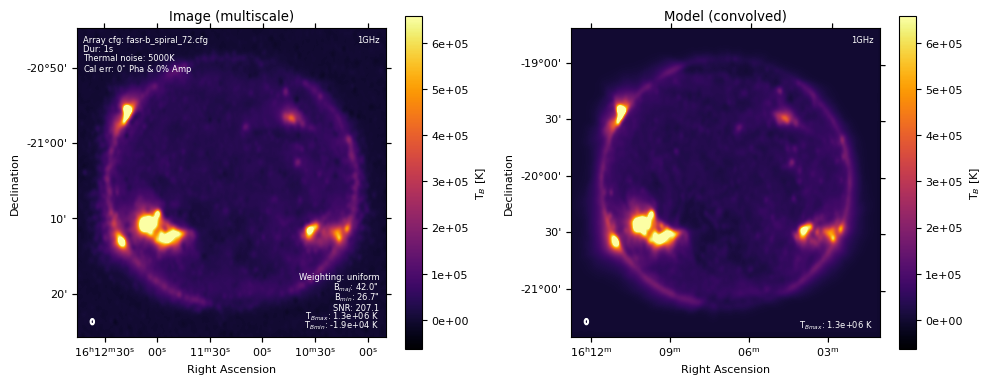

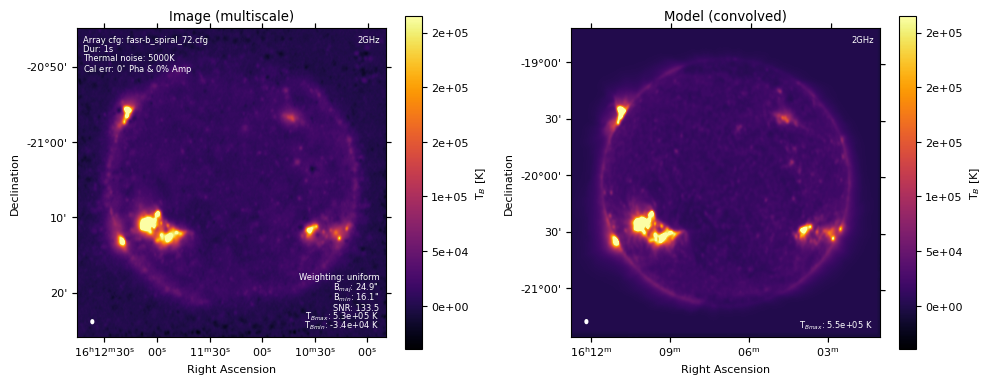

In [ ]:
%matplotlib inline
reload(fss)

import time

reftime = reftime.strftime('%Y/%m/%d/%H:%M:%S')

figdir = os.path.join(project, figsubfolder)
if not os.path.exists(figdir):
    os.makedirs(figdir)
    
caltbdir = os.path.join(project, 'caltbs')
if not os.path.exists(caltbdir):
    os.makedirs(caltbdir)

for config_file in config_files:
    cfg_suffix = os.path.basename(config_file.rstrip(".cfg"))
    for freqstr, imsize, cell, scale in zip(freq_list, imsizes, cells, scales):
        solar_model = f'{model_dir}/solar_disk_model_20201126.{freqstr}.fits'
        for noise in noise_levels:
            for phaerr, amperr in cal_errors:
                phaerr_deg = np.rad2deg(phaerr * 2 * np.pi)
                gaintable = [f'{caltbdir}/caltb_FASR_corrupt_{phaerr_deg:.0f}deg.ph',
                             f'{caltbdir}/caltb_FASR_corrupt_{np.int_(amperr * 100)}pct.amp']
                msname = fss.make_msname(project, target, freqstr, reftime_obj, duration, integration_time, config_file, noise)
                imname = fss.make_imname(msname, deconvolver, phaerr, amperr)
                if niter == 0:
                    imname = imname.replace(deconvolver, 'dirty')
                msfile = f'{msname}.ms'
                if os.path.exists(msfile):
                    if overwrite_ms:
                        os.system('rm -rf ' + msfile)
                    else:
                        pass
                
                if not os.path.exists(msfile):
                    print('Start generating ms')
                    fss.generate_ms(config_file, solar_model, reftime, freqstr, integration_time=integration_time,
                                    duration=duration,
                                    msname=msfile, noise=noise, usehourangle=True)

                if os.path.exists(f'{imname}.image'):
                    if overwrite_im:
                        junk = ['.image', '.model', '.mask', '.pb', '.psf', '.residual', '.sumwt']
                        for j in junk:
                            os.system(f'rm -rf {imname}{j}')

                if not os.path.exists(f'{imname}.image'):
                    tstart = time.time()
                    print('Start deconvolution')
                    if not os.path.exists(gaintable[0]):
                        gaintable = fss.generate_caltb(msfile, caltype=['ph', 'amp'], 
                                                       calerr=[phaerr, amperr], caltbdir=caltbdir)
                    clearcal(vis=msfile)
                    applycal(vis=msfile, gaintable=gaintable, applymode='calonly', calwt=False)
                    if deconvolver == 'hogbom':
                        tclean(vis=msfile, imagename=imname,
                               datacolumn='corrected',
                               field='', spw='', specmode='mfs', 
                               deconvolver=deconvolver, pblimit=0.01,
                               imsize=imsize, cell=cell,
                               weighting=weighting,
                               niter=niter,
                               interactive=False)
                    elif deconvolver == 'multiscale':
                        tclean(vis=msfile, imagename=imname,
                               datacolumn='corrected',
                               field='', spw='', specmode='mfs', 
                               deconvolver=deconvolver, scales=scale, 
                               gain=0.2, cycleniter=200, minpsffraction=0.1, pblimit=0.01,
                               imsize=imsize, cell=cell,
                               weighting=weighting,
                               niter=niter,
                               interactive=False)                        
                    junk = ['.model', '.mask', '.pb', '.psf', '.residual', '.sumwt']
                    for j in junk:
                        os.system(f'rm -rf {imname}{j}')
                    tend = time.time()
                    print(f'deconvolution completed in {(tend - tstart)/60.:.2f} minutes')
                    

                figname = os.path.join(figdir, f'fig-{os.path.basename(imname)}.jpg')
                #figname = os.path.join(figdir, f'fig-{os.path.basename(imname)}.ar.jpg')
                if os.path.exists(figname):
                    if overwrite_plot:
                        os.system(f'rm -rf {figname}')

                if not os.path.exists(figname):
                    reload(fss)
                    ## cleaned image
                    image1 = imname + '.image'
                    ## model image
                    image2 = os.path.join(project+'/msfiles/Quiet_Sun/', os.path.basename(solar_model.replace('.fits', '.im')))
                    ## meta information of the images
                    image_meta = {'title': [f'Image ({deconvolver})', 'Model (convolved)'],
                                  'freq': freqstr.lstrip("0"),
                                  'array_config': config_file,
                                  'noise': f'{1e6 * float(noise.rstrip("MK")):.0f}K',
                                  'cal_error': f'{phaerr_deg:.0f}'+r'$^{\circ}$ Pha' + f' & {np.int_(amperr * 100)}% Amp',
                                  'duration': f'{duration}s',
                                  'weighting': weighting,
                                  }
                    print('Start plotting')
                    fig, axs = fss.plot_two_casa_images_with_convolution(image1, image2,
                                                                         crop_fraction=(0.0, 1.0),
                                                                         #crop_fraction=((0.17, 0.37), (0.25, 0.45)),
                                                                         figsize=(15, 4),
                                                                         image_meta=image_meta,
                                                                         cmap='inferno',
                                                                         vmax=50,
                                                                         compare_two=False,
                                                                         contour_levels=[0.025, 0.05, 0.1, 0.2, 0.4,
                                                                                         0.8],
                                                                         conv_tag=f'.{cfg_suffix}',
                                                                         overwrite_conv=False)

                    fig.savefig(figname, dpi=300)

## Now do simulation using the PSI-MHD-derived model

In [18]:
# List of all available frequencies in GHz
freq_list = ['0.20GHz', '0.40GHz', '1.00GHz', '1.59GHz', '2.00GHz']
imsizes = [512, 512, 512, 512, 512]
cells = ['8arcsec', '8arcsec', '8arcsec', '8arcsec', '8arcsec']
scales = [[0, 4, 10, 50], [0, 4, 10, 40], [0, 4, 10, 40], [0, 4, 10, 40], [0, 4, 10, 40]]

selection = [0, 1, 2, 3, 4]
# Revise freq_list, imsizes, cells, and scales using the selection
freq_list = [freq_list[i] for i in selection]
imsizes = [imsizes[i] for i in selection]
cells = [cells[i] for i in selection]
scales = [scales[i] for i in selection]

# List of configurations
project = 'FASR-B'
config_files = ['fasr-b_spiral_72.cfg']

## Antenna temperature noise levels
tsys_all = [300.]

## Define the fractional gain errors tuples: (phase and amplitude)
# 6 degrees (or 1.7% of phase error is equivalent to 10% of amplitude error )
#cal_errors = [(0., 0.), (0.017, 0.1)]
cal_errors = [(0., 0.)]

# Define channel width and integration time
channel_width_mhz = 10. # channel width in MHz
integration_time = 1. # Time per integration in seconds
duration = 1. # Total imaging duration in seconds

# Reference timestamp for the observation series
reftime='2020-11-26T20:45:47'
solar_radius_asec = coordinates.sun.angular_radius(reftime).value

# Flags to control overwriting existing data products
overwrite_ms   = False  # Overwrite measurement set?
overwrite_im   = False  # Overwrite image products?
overwrite_plot = True  # Overwrite existing plots?

# Deconvolution algorithm choice
weighting = 'uniform'
#deconvolver = 'hogbom'
#niter = 0

deconvolver = 'multiscale'
niter = 10000

Total flux within primary beam used to calcuate the antenna temperature: 8.7 sfu
Tant: 574K
8.7469109375
Calculate antenna temperature from total flux 8.7469109375 sfu incident on the dish
Total noise temperature (K): 8.738e+02 K
Estimated SEFD: 1.432e+05 Jy
Estimated natural weighting point source sensitivity sigma_na: 4.477e-01 Jy/beam
Estimated uniform weighting point source sensitivity sigma_un: 6.219e-01 Jy/beam
Estimated noise per baseline per channel per polarization per integration: 3.201e+01 Jy for 2556 baselines
Start plotting
Applying a mask of 1.6 solar radii to calcuate rms outside of it.
Peak of fasr_fasr-b_spiral_72_Quiet_Sun_0.20GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr0deg_amperr0pct_multiscale.image: 1.224e+06 K
rms of fasr_fasr-b_spiral_72_Quiet_Sun_0.20GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr0deg_amperr0pct_multiscale.image (excluding solar disk): 2.780e+03 K
SNR of the image: 440.3
Peak of psi_solar_disk_model_20201126.0.20GHz.im: 9.588e+05 K
rms of psi_

/Users/binchen/Dropbox/Projects/FASR/fasr-array-config-simul/fasr_solar_simul.py:2718: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(ctick_labels)
/Users/binchen/Dropbox/Projects/FASR/fasr-array-config-simul/fasr_solar_simul.py:2763: UserWarning: FixedFormatter should only be used together with FixedLocator
  if compare_two:


Total flux within primary beam used to calcuate the antenna temperature: 23.8 sfu
Tant: 1558K
23.7513140625
Calculate antenna temperature from total flux 23.7513140625 sfu incident on the dish
Total noise temperature (K): 1.858e+03 K
Estimated SEFD: 3.044e+05 Jy
Estimated natural weighting point source sensitivity sigma_na: 9.521e-01 Jy/beam
Estimated uniform weighting point source sensitivity sigma_un: 1.105e+00 Jy/beam
Estimated noise per baseline per channel per polarization per integration: 6.807e+01 Jy for 2556 baselines
Start plotting
Applying a mask of 1.6 solar radii to calcuate rms outside of it.
Peak of fasr_fasr-b_spiral_72_Quiet_Sun_0.40GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr0deg_amperr0pct_multiscale.image: 1.768e+06 K
rms of fasr_fasr-b_spiral_72_Quiet_Sun_0.40GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr0deg_amperr0pct_multiscale.image (excluding solar disk): 2.137e+03 K
SNR of the image: 827.1
Peak of psi_solar_disk_model_20201126.0.40GHz.im: 1.370e+06 K
rms of 

/Users/binchen/Dropbox/Projects/FASR/fasr-array-config-simul/fasr_solar_simul.py:2718: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(ctick_labels)
/Users/binchen/Dropbox/Projects/FASR/fasr-array-config-simul/fasr_solar_simul.py:2763: UserWarning: FixedFormatter should only be used together with FixedLocator
  if compare_two:


Total flux within primary beam used to calcuate the antenna temperature: 70.5 sfu
Tant: 4624K
70.479075
Calculate antenna temperature from total flux 70.479075 sfu incident on the dish
Total noise temperature (K): 4.924e+03 K
Estimated SEFD: 8.066e+05 Jy
Estimated natural weighting point source sensitivity sigma_na: 2.523e+00 Jy/beam
Estimated uniform weighting point source sensitivity sigma_un: 2.598e+00 Jy/beam
Estimated noise per baseline per channel per polarization per integration: 1.804e+02 Jy for 2556 baselines
Start plotting
Applying a mask of 1.6 solar radii to calcuate rms outside of it.
Peak of fasr_fasr-b_spiral_72_Quiet_Sun_1.00GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr0deg_amperr0pct_multiscale.image: 2.226e+06 K
rms of fasr_fasr-b_spiral_72_Quiet_Sun_1.00GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr0deg_amperr0pct_multiscale.image (excluding solar disk): 3.213e+03 K
SNR of the image: 692.9
Peak of psi_solar_disk_model_20201126.1.00GHz.im: 1.755e+06 K
rms of psi_sola

/Users/binchen/Dropbox/Projects/FASR/fasr-array-config-simul/fasr_solar_simul.py:2718: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(ctick_labels)
/Users/binchen/Dropbox/Projects/FASR/fasr-array-config-simul/fasr_solar_simul.py:2763: UserWarning: FixedFormatter should only be used together with FixedLocator
  if compare_two:


Total flux within primary beam used to calcuate the antenna temperature: 121.5 sfu
Tant: 7973K
121.53025
Calculate antenna temperature from total flux 121.53025 sfu incident on the dish
Total noise temperature (K): 8.273e+03 K
Estimated SEFD: 1.355e+06 Jy
Estimated natural weighting point source sensitivity sigma_na: 4.239e+00 Jy/beam
Estimated uniform weighting point source sensitivity sigma_un: 4.301e+00 Jy/beam
Estimated noise per baseline per channel per polarization per integration: 3.031e+02 Jy for 2556 baselines
Start plotting
Applying a mask of 1.6 solar radii to calcuate rms outside of it.
Peak of fasr_fasr-b_spiral_72_Quiet_Sun_1.59GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr0deg_amperr0pct_multiscale.image: 1.594e+06 K
rms of fasr_fasr-b_spiral_72_Quiet_Sun_1.59GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr0deg_amperr0pct_multiscale.image (excluding solar disk): 5.906e+03 K
SNR of the image: 269.9
Peak of psi_solar_disk_model_20201126.1.59GHz.im: 1.694e+06 K
rms of psi_sol

/Users/binchen/Dropbox/Projects/FASR/fasr-array-config-simul/fasr_solar_simul.py:2718: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(ctick_labels)
/Users/binchen/Dropbox/Projects/FASR/fasr-array-config-simul/fasr_solar_simul.py:2763: UserWarning: FixedFormatter should only be used together with FixedLocator
  if compare_two:


Total flux within primary beam used to calcuate the antenna temperature: 161.6 sfu
Tant: 10601K
161.5952375
Calculate antenna temperature from total flux 161.5952375 sfu incident on the dish
Total noise temperature (K): 1.090e+04 K
Estimated SEFD: 1.786e+06 Jy
Estimated natural weighting point source sensitivity sigma_na: 5.585e+00 Jy/beam
Estimated uniform weighting point source sensitivity sigma_un: 5.636e+00 Jy/beam
Estimated noise per baseline per channel per polarization per integration: 3.993e+02 Jy for 2556 baselines
Start plotting
Applying a mask of 1.6 solar radii to calcuate rms outside of it.
Peak of fasr_fasr-b_spiral_72_Quiet_Sun_2.00GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr0deg_amperr0pct_multiscale.image: 1.158e+06 K
rms of fasr_fasr-b_spiral_72_Quiet_Sun_2.00GHz_20201126T20UT_dur1s_int1s_noise300K_phaerr0deg_amperr0pct_multiscale.image (excluding solar disk): 2.242e+04 K
SNR of the image: 51.6
Peak of psi_solar_disk_model_20201126.2.00GHz.im: 1.508e+06 K
rms of psi

/Users/binchen/Dropbox/Projects/FASR/fasr-array-config-simul/fasr_solar_simul.py:2718: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(ctick_labels)
/Users/binchen/Dropbox/Projects/FASR/fasr-array-config-simul/fasr_solar_simul.py:2763: UserWarning: FixedFormatter should only be used together with FixedLocator
  if compare_two:


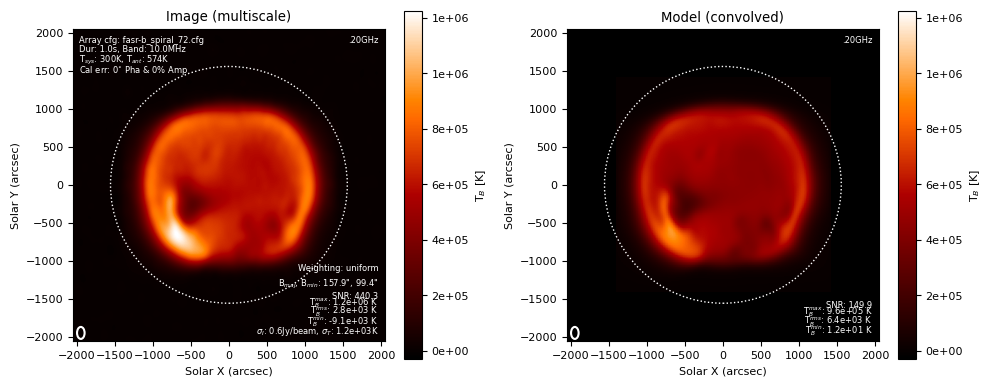

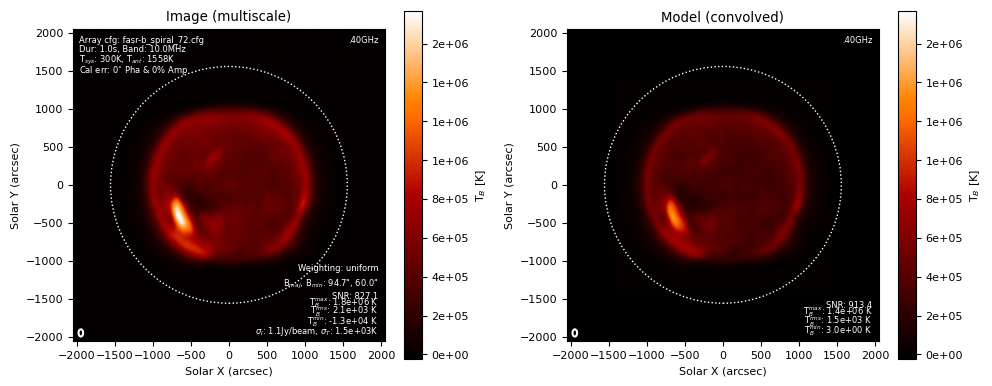

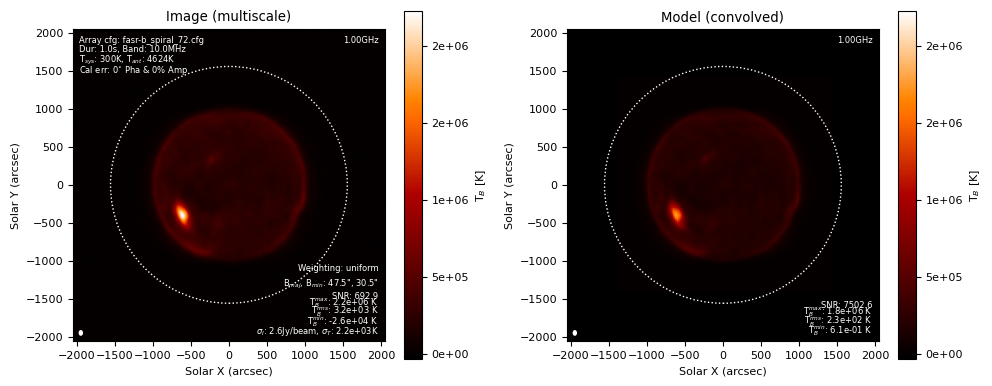

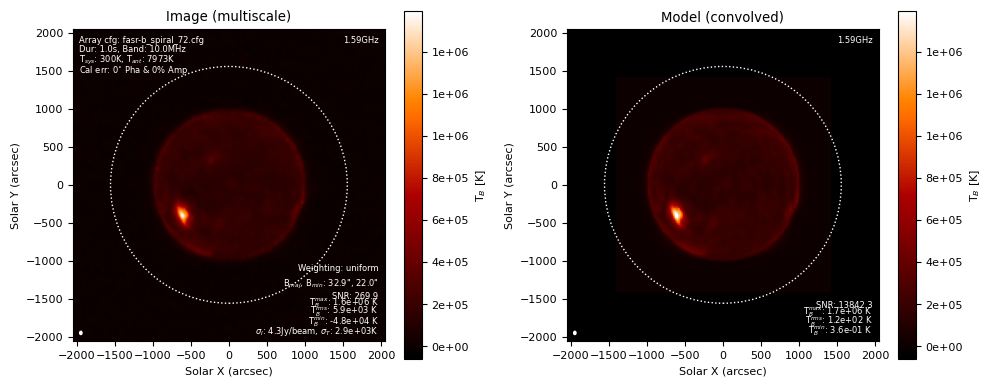

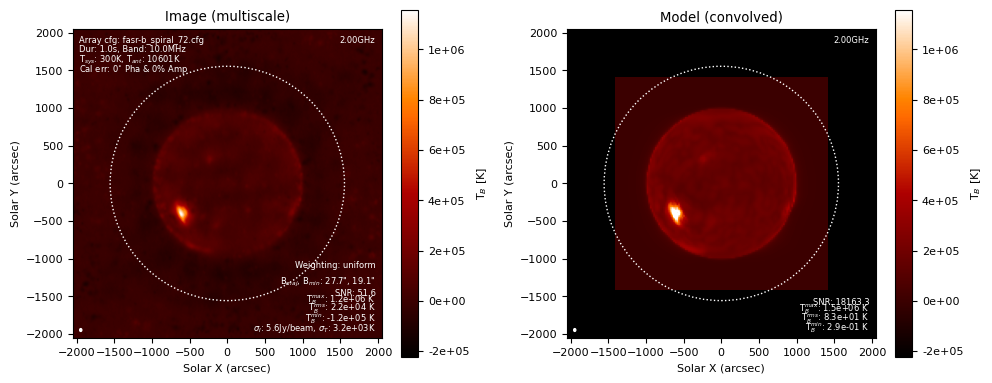

In [ ]:
%matplotlib inline
reload(fss)

import time

reftime_casa = Time(reftime).strftime('%Y/%m/%d/%H:%M:%S')

figdir = os.path.join(project, figsubfolder)
if not os.path.exists(figdir):
    os.makedirs(figdir)
    
caltbdir = os.path.join(project, 'caltbs')
if not os.path.exists(caltbdir):
    os.makedirs(caltbdir)

for config_file in config_files:
    cfg_suffix = os.path.basename(config_file.rstrip(".cfg"))
    for freqstr, imsize, cell, scale in zip(freq_list, imsizes, cells, scales):
        solar_model = f'{model_dir}/psi_solar_disk_model_20201126.{freqstr}.fits'
        for tsys in tsys_all:
            # Calculate theoretical sensitivity with natural weighting
            antenna_params = np.genfromtxt(config_file, comments='#')
            dish_diameter = antenna_params[0, 3]
            uv_cell = 1. / (imsize * float(cell.rstrip('arcsec')) / 206265.)
            total_flux = fss.calc_total_flux_on_dish(solar_model, dish_diameter=dish_diameter, freqghz=freqstr)
            tant = fss.total_flux_to_tant(total_flux, eta_a=0.6, dish_diameter=dish_diameter)
            print(f'Tant: {tant:.0f}K')
            noisejy, sigma_na, sigma_un = fss.calc_noise(tsys, config_file, dish_diameter=dish_diameter, 
                                                         total_flux=total_flux, duration=duration,
                                                         integration_time=integration_time, 
                                                         channel_width_mhz=channel_width_mhz, 
                                                         freqghz=freqstr, uv_cell=uv_cell)
            sigma_jy = sigma_un / np.sqrt((duration / integration_time))
                
            for phaerr, amperr in cal_errors:
                phaerr_deg = np.rad2deg(phaerr * 2 * np.pi)
                gaintable = [f'caltb_FASR_corrupt_{phaerr_deg:.0f}deg.ph',
                             f'caltb_FASR_corrupt_{np.int_(amperr * 100)}pct.amp']
                msname = fss.make_msname(project, target, freqstr, Time(reftime).datetime, duration, integration_time, config_file, tsys)
                imname = fss.make_imname(msname, deconvolver, phaerr, amperr)
                if niter == 0:
                    imname = imname.replace(deconvolver, 'dirty')
                msfile = f'{msname}.ms'
                if os.path.exists(msfile):
                    if overwrite_ms:
                        os.system('rm -rf ' + msfile)
                    else:
                        pass
                
                if not os.path.exists(msfile):
                    print('Start generating ms')
                    msfile = fss.generate_ms(config_file, solar_model, reftime_casa, freqstr, integration_time=integration_time,
                                    duration=duration, channel_width_mhz=channel_width_mhz, 
                                    msname=msfile, tsys=tsys, usehourangle=True)

                if os.path.exists(f'{imname}.image'):
                    if overwrite_im:
                        junk = ['.image', '.model', '.mask', '.pb', '.psf', '.residual', '.sumwt']
                        for j in junk:
                            os.system(f'rm -rf {imname}{j}')

                if not os.path.exists(f'{imname}.image'):
                    tstart = time.time()
                    print('Start deconvolution')
                    if not os.path.exists(gaintable[0]):
                        gaintable = fss.generate_caltb(msfile, caltype=['ph', 'amp'], 
                                                       calerr=[phaerr, amperr], caltbdir=caltbdir)
                    clearcal(vis=msfile)
                    applycal(vis=msfile, gaintable=gaintable, applymode='calonly', calwt=False)
                    if deconvolver == 'hogbom':
                        tclean(vis=msfile, imagename=imname,
                               datacolumn='corrected',
                               field='', spw='', specmode='mfs', 
                               deconvolver=deconvolver, pblimit=0.01,
                               imsize=imsize, cell=cell,
                               weighting=weighting,
                               niter=niter,
                               interactive=False)
                    elif deconvolver == 'multiscale':
                        tclean(vis=msfile, imagename=imname,
                               datacolumn='corrected',
                               field='', spw='', specmode='mfs', 
                               deconvolver=deconvolver, scales=scale, 
                               gain=0.2, cycleniter=200, minpsffraction=0.1, pblimit=0.01,
                               imsize=imsize, cell=cell,
                               weighting=weighting,
                               niter=niter,
                               interactive=False)                        
                    junk = ['.model', '.mask', '.pb', '.psf', '.residual', '.sumwt']
                    for j in junk:
                        os.system(f'rm -rf {imname}{j}')
                    tend = time.time()
                    print(f'deconvolution completed in {(tend - tstart)/60.:.2f} minutes')
                    

                figname = os.path.join(figdir, f'fig-{os.path.basename(imname)}.jpg')
                #figname = os.path.join(figdir, f'fig-{os.path.basename(imname)}.ar.jpg')
                if os.path.exists(figname):
                    if overwrite_plot:
                        os.system(f'rm -rf {figname}')

                if not os.path.exists(figname):
                    reload(fss)
                    ## cleaned image
                    image1 = imname + '.image'
                    ## model image
                    image2 = os.path.join(project+'/msfiles/Quiet_Sun/', os.path.basename(solar_model.replace('.fits', '.im')))
                    ## meta information of the images
                    image_meta = {'title': [f'Image ({deconvolver})', 'Model (convolved)'],
                                  'freq': freqstr,
                                  'array_config': config_file,
                                  'tsys': f'{tsys:.0f}K',
                                  'tant': f'{tant:.0f}K',
                                  'sigma_jy': f'{sigma_jy:.1f}Jy/beam',
                                  'cal_error': f'{phaerr_deg:.0f}'+r'$^{\circ}$ Pha' + f' & {np.int_(amperr * 100)}% Amp',
                                  'duration': f'{duration}s',
                                  'bandwidth': f'{channel_width_mhz}MHz',
                                  'weighting': weighting,
                                  }
                    print('Start plotting')
                    fig, axs = fss.plot_two_casa_images_with_convolution(image1, image2,
                                                                         crop_fraction=(0.0, 1.0),
                                                                         #crop_fraction=((0.17, 0.37), (0.25, 0.45)),
                                                                         rms_mask_radius=1.6,
                                                                         reftime=reftime,
                                                                         figsize=(15, 4),
                                                                         image_meta=image_meta,
                                                                         cmap='hinodexrt',
                                                                         vmax=100,
                                                                         compare_two=False,
                                                                         contour_levels=[0.025, 0.05, 0.1, 0.2, 0.4,
                                                                                         0.8],
                                                                         conv_tag=f'.{cfg_suffix}',
                                                                         overwrite_conv=False)

                    fig.savefig(figname, dpi=300)